In [1]:
# Install KISS-ICP and Plotting tools
import os

import numpy as np
from kiss_icp.datasets import dataset_factory
from kiss_icp.pipeline import OdometryPipeline
import matplotlib.pyplot as plt
import tqdm
from model import PointTransformerV3
import torch
from collections import OrderedDict

/home/vladislav/miniconda3/envs/pointcept/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vladislav/miniconda3/envs/pointcept/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
segmodel = PointTransformerV3(
    in_channels=4,
    order=["z", "z-trans", "hilbert", "hilbert-trans"],
    stride=(2, 2, 2, 2),
    enc_depths=(2, 2, 2, 6, 2),
    enc_channels=(32, 64, 128, 256, 512),
    enc_num_head=(2, 4, 8, 16, 32),
    enc_patch_size=(128, 128, 128, 128, 128),
    dec_depths=(2, 2, 2, 2),
    dec_channels=(64, 64, 128, 256),
    dec_num_head=(4, 4, 8, 16),
    dec_patch_size=(128, 128, 128, 128),
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    attn_drop=0.0,
    proj_drop=0.0,
    drop_path=0.3,
    shuffle_orders=True,
    pre_norm=True,
    enable_rpe=False,
    enable_flash=False,
    upcast_attention=False,
    upcast_softmax=False,
    cls_mode=False,
    pdnorm_bn=False,
    pdnorm_ln=False,
    pdnorm_decouple=True,
    pdnorm_adaptive=False,
    pdnorm_affine=True,
    pdnorm_conditions=("nuScenes", "SemanticKITTI", "Waymo"),
).cuda()
seg_head = torch.nn.Linear(64, 19).cuda()

checkpoint = torch.load(
    "best_model.pth", map_location=lambda storage, loc: storage.cuda()
)

weight_backbone = OrderedDict()
weight_seg_head = OrderedDict()

for key, value in checkpoint.items():
    if "backbone" in key:
        weight_backbone[key.replace("module.backbone.", "")] = value
    elif "seg_head" in key:
        weight_seg_head[key.replace("module.seg_head.", "")] = value

load_state_info1 = segmodel.load_state_dict(weight_backbone, strict=True)
load_state_info2 = seg_head.load_state_dict(weight_seg_head, strict=True)
assert load_state_info1 and load_state_info2

In [3]:
data_root = ".."
sequence_root = os.path.join(data_root, "SemanticKITTI/dataset/sequences/08/velodyne")
pipeline = OdometryPipeline(
    dataset=dataset_factory(
        dataloader="generic",
        data_dir=sequence_root,
    )
)

# seq_res = pipeline.run()
# seq_res.print()
poses = np.asarray(pipeline.poses).reshape(len(pipeline.poses), 4, 4)
poses = np.load("results/latest/velodyne_poses.npy")

[WARNING] Reading .bin files, the only format supported is the KITTI format


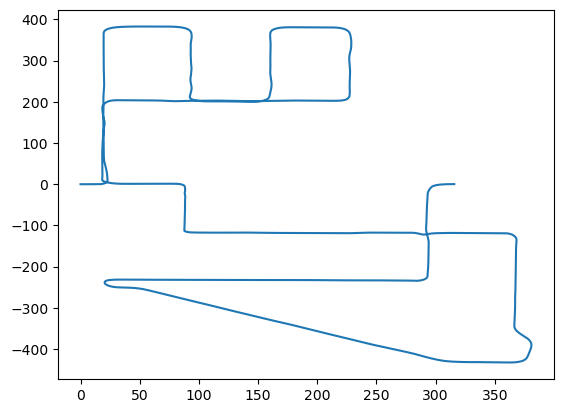

In [4]:
plt.plot(poses[:,0,3], poses[:,1,3])

In [5]:
pcd_files = sorted(os.listdir(sequence_root))

In [6]:
import time

In [7]:
learning_map_inv = {
            "ignore_index": -1,  # "unlabeled"
            0: 10,  # "car"
            1: 11,  # "bicycle"
            2: 15,  # "motorcycle"
            3: 18,  # "truck"
            4: 20,  # "other-vehicle"
            5: 30,  # "person"
            6: 31,  # "bicyclist"
            7: 32,  # "motorcyclist"
            8: 40,  # "road"
            9: 44,  # "parking"
            10: 48,  # "sidewalk"
            11: 49,  # "other-ground"
            12: 50,  # "building"
            13: 51,  # "fence"
            14: 70,  # "vegetation"
            15: 71,  # "trunk"
            16: 72,  # "terrain"
            17: 80,  # "pole"
            18: 81,  # "traffic-sign"
        }

In [8]:
pcd_heap = []
heap_size = 1
for pcd_file_id in tqdm.tqdm(range(len(pcd_files))):
    pts = np.fromfile(
        os.path.join(sequence_root, pcd_files[pcd_file_id]), dtype=np.float32
    ).reshape((-1, 4))
    pts_hom = np.hstack([pts[:, :3], np.ones((pts.shape[0], 1), dtype=pts.dtype)])
    transformed = (
        poses[pcd_file_id]
        @ np.linalg.inv(
            poses[pcd_file_id - heap_size if pcd_file_id - heap_size >= 0 else 0]
        )
        @ pts_hom.T
    ).T
    pts[:, :3] = transformed[:, :3]
    pcd_heap.append(pts.copy())
    if len(pcd_heap) > heap_size:
        pcd_heap.pop(0)
    heaped_pts = torch.as_tensor(np.vstack(pcd_heap)).cuda()
    
    data = {
        "feat": heaped_pts,
        "coord": heaped_pts[:, :3],
        "batch": torch.zeros(heaped_pts.shape[0],dtype=int).cuda(),
        "grid_size": 0.1
    }
    start_time = time.time()
    probs = torch.softmax(seg_head(segmodel(data)["feat"]), dim=1)
    labels = torch.argmax(probs, dim=1).cpu().numpy()
    labels = np.vectorize(learning_map_inv.__getitem__)(
                labels & 0xFFFF
            ).astype(np.int32)
    del data, heaped_pts, probs
    # if pcd_file_id > 5:
    # break

  8%|▊         | 342/4071 [01:26<15:38,  3.98it/s]


KeyboardInterrupt: 